# Eye Movement Analysis for Brain Disorder Detection

This notebook provides a comprehensive analysis of eye movement data collected from wearable sensors to detect brain disorders.

## Overview

Eye movements are controlled by complex neural circuits and can serve as sensitive biomarkers for neurological conditions. This analysis includes:

1. Data preprocessing and cleaning
2. Feature extraction from eye movement signals
3. Statistical analysis comparing healthy and disorder groups
4. Dimensionality reduction using PCA
5. Machine learning classification
6. Visualization of results


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Load and Explore Data


In [2]:
# For demonstration, generate synthetic eye movement data
np.random.seed(42)

n_subjects = 50
n_timepoints = 1000
sampling_rate = 1000  # Hz

data_list = []

for i in range(n_subjects):
    # Healthy group: smooth eye movements
    t = np.linspace(0, 1, n_timepoints)
    x_healthy = np.cumsum(np.random.randn(n_timepoints) * 0.01)
    y_healthy = np.cumsum(np.random.randn(n_timepoints) * 0.01)
    
    for j in range(n_timepoints):
        data_list.append({
            'subject_id': f'healthy_{i}',
            'time': t[j],
            'x_position': x_healthy[j],
            'y_position': y_healthy[j],
            'group': 'healthy'
        })
    
    # Disorder group: more erratic movements
    x_disorder = np.cumsum(np.random.randn(n_timepoints) * 0.05)
    y_disorder = np.cumsum(np.random.randn(n_timepoints) * 0.05)
    
    for j in range(n_timepoints):
        data_list.append({
            'subject_id': f'disorder_{i}',
            'time': t[j],
            'x_position': x_disorder[j],
            'y_position': y_disorder[j],
            'group': 'disorder'
        })

data = pd.DataFrame(data_list)
print(f"Data shape: {data.shape}")
print(f"\nGroup distribution:")
print(data['group'].value_counts())
print("\nFirst few rows:")
print(data.head())


Data shape: (100000, 5)

Group distribution:
group
healthy     50000
disorder    50000
Name: count, dtype: int64

First few rows:
  subject_id      time  x_position  y_position    group
0  healthy_0  0.000000    0.004967    0.013994  healthy
1  healthy_0  0.001001    0.003584    0.023240  healthy
2  healthy_0  0.002002    0.010061    0.023836  healthy
3  healthy_0  0.003003    0.025292    0.017367  healthy
4  healthy_0  0.004004    0.022950    0.024349  healthy


## 3. Feature Extraction and Analysis

This section extracts meaningful features from eye movement data including velocity, acceleration, saccade metrics, and fixation characteristics.


In [3]:
def extract_features(data, sampling_rate=1000):
    """Extract features from eye movement data for each subject."""
    features_list = []
    
    for subject_id in data['subject_id'].unique():
        subject_data = data[data['subject_id'] == subject_id].sort_values('time')
        
        if len(subject_data) < 2:
            continue
        
        # Calculate velocity
        x_velocity = np.diff(subject_data['x_position'].values) * sampling_rate
        y_velocity = np.diff(subject_data['y_position'].values) * sampling_rate
        velocity = np.sqrt(x_velocity**2 + y_velocity**2)
        
        # Calculate acceleration
        acceleration = np.diff(velocity) * sampling_rate
        
        # Saccade detection
        saccade_threshold = np.percentile(velocity, 95)
        saccades = velocity > saccade_threshold
        
        # Extract features
        features = {
            'subject_id': subject_id,
            'mean_velocity': np.mean(velocity),
            'std_velocity': np.std(velocity),
            'max_velocity': np.max(velocity),
            'saccade_count': np.sum(saccades),
            'saccade_rate': np.sum(saccades) / len(velocity),
            'group': subject_data['group'].iloc[0]
        }
        
        features_list.append(features)
    
    return pd.DataFrame(features_list)

# Extract features
features_df = extract_features(data, sampling_rate=sampling_rate)
print(f"\nExtracted features shape: {features_df.shape}")
print("\nFeature columns:")
print(features_df.columns.tolist())
print("\nFirst few rows:")
print(features_df.head())



Extracted features shape: (100, 7)

Feature columns:
['subject_id', 'mean_velocity', 'std_velocity', 'max_velocity', 'saccade_count', 'saccade_rate', 'group']

First few rows:
   subject_id  mean_velocity  std_velocity  max_velocity  saccade_count  \
0   healthy_0      12.324016      6.619329     42.313779             50   
1  disorder_0      62.911089     32.990402    202.599413             50   
2   healthy_1      12.477469      6.681842     36.487689             50   
3  disorder_1      64.729012     33.882967    190.594139             50   
4   healthy_2      12.349761      6.555139     41.820403             50   

   saccade_rate     group  
0       0.05005   healthy  
1       0.05005  disorder  
2       0.05005   healthy  
3       0.05005  disorder  
4       0.05005   healthy  


## 4. Statistical Analysis

Perform t-tests to compare features between healthy and disorder groups.


In [4]:
# Separate features and labels
feature_cols = [col for col in features_df.columns 
                if col not in ['subject_id', 'group']]
X = features_df[feature_cols]
y = features_df['group']

# Perform t-tests
healthy_data = features_df[features_df['group'] == 'healthy'][feature_cols]
disorder_data = features_df[features_df['group'] == 'disorder'][feature_cols]

statistical_results = []

for feature in feature_cols:
    t_stat, p_value = stats.ttest_ind(
        healthy_data[feature].dropna(),
        disorder_data[feature].dropna()
    )
    
    statistical_results.append({
        'feature': feature,
        't_statistic': t_stat,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'healthy_mean': healthy_data[feature].mean(),
        'disorder_mean': disorder_data[feature].mean()
    })

stats_df = pd.DataFrame(statistical_results)
print("Statistical Analysis Results:")
print("=" * 80)
print(stats_df.to_string(index=False))

print("\n\nSignificant features (p < 0.05):")
significant_features = stats_df[stats_df['significant'] == True]
print(significant_features[['feature', 'p_value']].to_string(index=False))


Statistical Analysis Results:
      feature  t_statistic       p_value  significant  healthy_mean  disorder_mean
mean_velocity  -360.567609 7.494188e-155         True     12.517044      62.766622
 std_velocity  -261.085924 3.983377e-141         True      6.502288      32.887408
 max_velocity   -58.218069  7.927188e-78         True     38.434284     195.199848
saccade_count          NaN           NaN        False     50.000000      50.000000
 saccade_rate          NaN           NaN        False      0.050050       0.050050


Significant features (p < 0.05):
      feature       p_value
mean_velocity 7.494188e-155
 std_velocity 3.983377e-141
 max_velocity  7.927188e-78


## 5. Machine Learning Classification

Train and evaluate machine learning models to classify eye movement patterns.


In [5]:
# Scale features and apply PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y
)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print("Random Forest Classifier Results:")
print("=" * 60)
print(f"Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_pred))


Random Forest Classifier Results:
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

    disorder       1.00      1.00      1.00        10
     healthy       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


Confusion Matrix:
[[10  0]
 [ 0 10]]


## 6. Visualization

Create comprehensive visualizations of the analysis results.


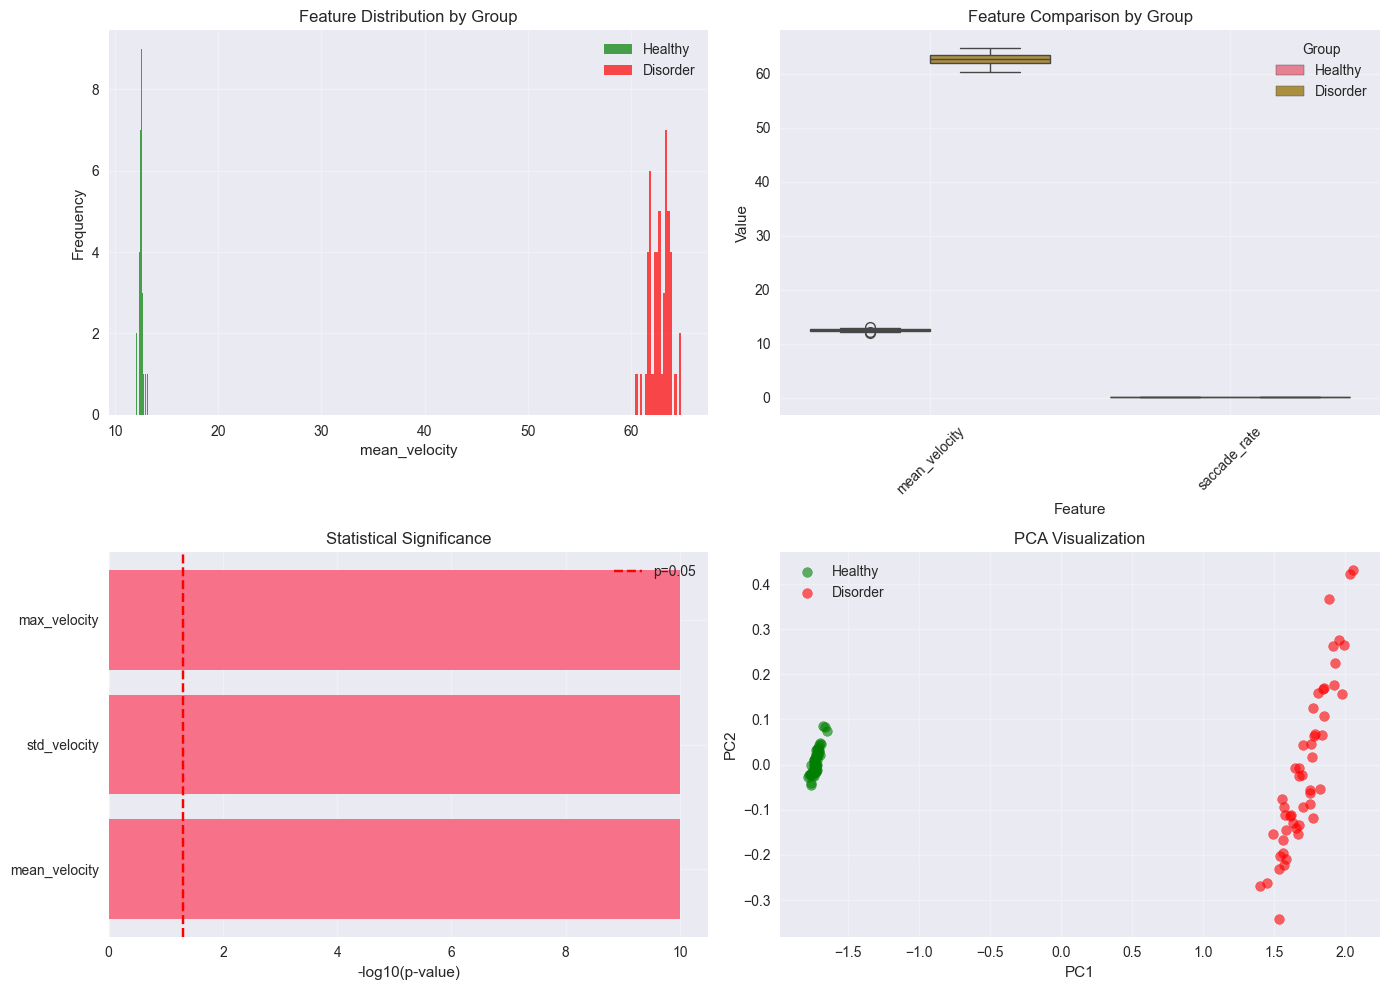

Visualizations saved!


In [6]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature distribution
feature = 'mean_velocity'
axes[0, 0].hist(healthy_data[feature], alpha=0.7, label='Healthy', bins=20, color='green')
axes[0, 0].hist(disorder_data[feature], alpha=0.7, label='Disorder', bins=20, color='red')
axes[0, 0].set_xlabel(feature)
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Feature Distribution by Group')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
key_features = ['mean_velocity', 'saccade_rate']
plot_data = []
for feature in key_features:
    if feature in feature_cols:
        plot_data.extend([
            {'Feature': feature, 'Value': val, 'Group': 'Healthy'} 
            for val in healthy_data[feature].values
        ])
        plot_data.extend([
            {'Feature': feature, 'Value': val, 'Group': 'Disorder'} 
            for val in disorder_data[feature].values
        ])

plot_df = pd.DataFrame(plot_data)
sns.boxplot(data=plot_df, x='Feature', y='Value', hue='Group', ax=axes[0, 1])
axes[0, 1].set_title('Feature Comparison by Group')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# P-value visualization
axes[1, 0].barh(stats_df['feature'], -np.log10(stats_df['p_value'] + 1e-10))
axes[1, 0].axvline(-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
axes[1, 0].set_xlabel('-log10(p-value)')
axes[1, 0].set_title('Statistical Significance')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# PCA visualization
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])
pca_df['group'] = y.values
healthy_pca = pca_df[pca_df['group'] == 'healthy']
disorder_pca = pca_df[pca_df['group'] == 'disorder']

axes[1, 1].scatter(healthy_pca['PC1'], healthy_pca['PC2'], 
                   alpha=0.6, label='Healthy', color='green', s=50)
axes[1, 1].scatter(disorder_pca['PC1'], disorder_pca['PC2'], 
                   alpha=0.6, label='Disorder', color='red', s=50)
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')
axes[1, 1].set_title('PCA Visualization')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eye_movement_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Visualizations saved!")
